In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# constants
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
BATCH_SIZE = 32
AE_EPOCHS = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Imported')
print('Used device:', device)

Imported
Used device: cuda


### Data preprocessing

In [2]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]
    
# loading dataset
data = np.load('./data/brats_3d_dataset.npy')
flair, t1ce = data[:, 0, None, ...], data[:, 1, None, ...]
N_VOLUMES, _, W, H, N_SLICES = flair.shape

# normalizing the data between -1 and 1
n_max_flair = [flair[i].max() for i in range(N_VOLUMES)]
n_max_t1ce = [t1ce[i].max() for i in range(N_VOLUMES)]

for idx in range(0, N_VOLUMES):
    flair[idx] = (2 * flair[idx] / n_max_flair[idx] - 1).astype(np.float32)
    t1ce[idx] = (2 * t1ce[idx] / n_max_t1ce[idx] - 1).astype(np.float32)

flair, t1ce = flair.clip(-1, 1), t1ce.clip(-1, 1)

# keeping track on slice positions for positional embedding
slice_positions = np.arange(N_SLICES)[None, :].repeat(N_VOLUMES, axis=0)
slice_positions = slice_positions.flatten()

# switching to 2D
flair = flair.transpose(0, 4, 1, 2, 3).reshape(N_VOLUMES * N_SLICES, -1, W, H)
t1ce = t1ce.transpose(0, 4, 1, 2, 3).reshape(N_VOLUMES * N_SLICES, -1, W, H)

# removing empty slices
# empty_slices_indices = np.where(np.any(flair, axis=(1, 2, 3)) == True)[0]
# flair, t1ce, mask = flair[empty_slices_indices], t1ce[empty_slices_indices], mask[empty_slices_indices]

# dataset and dataloader
train_dataset = IdentityDataset(flair, t1ce, slice_positions)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=8, pin_memory=True
)

print('Data shape: {}'.format(flair.shape))
print('Max: {}'.format(flair.max()))
print('Min: {}'.format(flair.min()))
print('Data loaded')

Data shape: (32000, 1, 128, 128)
Max: 1.0
Min: -1.0
Data loaded


### Training reconstruction model

In [3]:
def format_dict(d):
    return ' -- '.join([f'{k}: {v:.4f}' for k, v in d.items()])

def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQAutoencoder has 59.73 M params.


total_loss: 0.3817 -- quant_loss: 0.0020 -- nll_loss: 0.3254 -- rec_loss: 0.3254 -- p_loss: 0.2078 -- d_weight: 0.0382 -- disc_factor: 1.0000 -- g_loss: 1.4229 -- cos_sim: 1.7306 -- disc_loss: 0.0007 -- logits_real: 1.8369 -- logits_fake: -1.4229: 100%|██████████| 1000/1000 [12:06<00:00,  1.38it/s] 
total_loss: 18.2549 -- quant_loss: 18.1347 -- nll_loss: 0.1257 -- rec_loss: 0.1257 -- p_loss: 0.0931 -- d_weight: 0.0305 -- disc_factor: 1.0000 -- g_loss: -0.1813 -- cos_sim: 0.8385 -- disc_loss: 1.1738 -- logits_real: -0.1467 -- logits_fake: 0.1813: 100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]
total_loss: 21.8208 -- quant_loss: 21.7183 -- nll_loss: 0.1034 -- rec_loss: 0.1034 -- p_loss: 0.0739 -- d_weight: 0.0107 -- disc_factor: 1.0000 -- g_loss: -0.0842 -- cos_sim: 0.7195 -- disc_loss: 1.0195 -- logits_real: 0.0745 -- logits_fake: 0.0842: 100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]
total_loss: 22.3384 -- quant_loss: 22.2432 -- nll_loss: 0.0956 -- rec_loss: 0.0956 -- p_loss: 

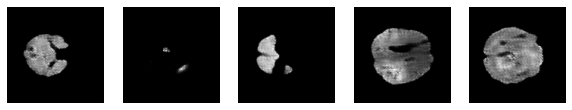

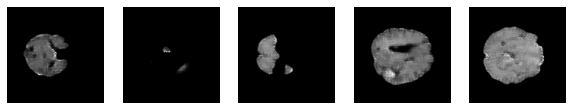

total_loss: 15.2358 -- quant_loss: 15.1449 -- nll_loss: 0.0851 -- rec_loss: 0.0851 -- p_loss: 0.0638 -- d_weight: 0.0055 -- disc_factor: 1.0000 -- g_loss: 1.0576 -- cos_sim: 0.5962 -- disc_loss: 0.7886 -- logits_real: -0.3264 -- logits_fake: -1.0576: 100%|██████████| 1000/1000 [11:01<00:00,  1.51it/s]
total_loss: 8.3618 -- quant_loss: 8.2900 -- nll_loss: 0.0705 -- rec_loss: 0.0705 -- p_loss: 0.0518 -- d_weight: 0.0020 -- disc_factor: 1.0000 -- g_loss: 0.6489 -- cos_sim: 0.7142 -- disc_loss: 0.7891 -- logits_real: -0.1742 -- logits_fake: -0.6489: 100%|██████████| 1000/1000 [12:02<00:00,  1.38it/s] 
total_loss: 6.6632 -- quant_loss: 6.5816 -- nll_loss: 0.0791 -- rec_loss: 0.0791 -- p_loss: 0.0565 -- d_weight: 0.0081 -- disc_factor: 1.0000 -- g_loss: 0.2952 -- cos_sim: 0.7855 -- disc_loss: 0.7700 -- logits_real: 0.2094 -- logits_fake: -0.2952: 100%|██████████| 1000/1000 [11:59<00:00,  1.39it/s]  
total_loss: 2.5963 -- quant_loss: 2.5437 -- nll_loss: 0.0516 -- rec_loss: 0.0516 -- p_loss: 0

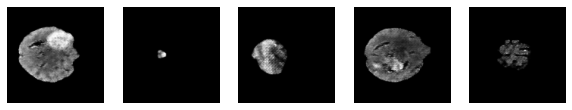

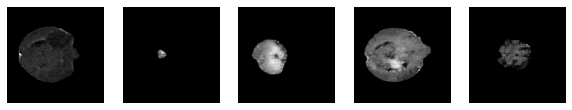

total_loss: 2.7003 -- quant_loss: 2.6370 -- nll_loss: 0.0644 -- rec_loss: 0.0644 -- p_loss: 0.0443 -- d_weight: 0.0050 -- disc_factor: 1.0000 -- g_loss: -0.2264 -- cos_sim: 0.9338 -- disc_loss: 0.9028 -- logits_real: 0.4355 -- logits_fake: 0.2264: 100%|██████████| 1000/1000 [12:13<00:00,  1.36it/s]
total_loss: 1.9094 -- quant_loss: 1.8544 -- nll_loss: 0.0541 -- rec_loss: 0.0541 -- p_loss: 0.0379 -- d_weight: 0.0039 -- disc_factor: 1.0000 -- g_loss: 0.2510 -- cos_sim: 1.0240 -- disc_loss: 0.9434 -- logits_real: -0.1208 -- logits_fake: -0.2510: 100%|██████████| 1000/1000 [12:15<00:00,  1.36it/s]
total_loss: 0.9285 -- quant_loss: 0.8839 -- nll_loss: 0.0456 -- rec_loss: 0.0456 -- p_loss: 0.0322 -- d_weight: 0.0049 -- disc_factor: 1.0000 -- g_loss: -0.2198 -- cos_sim: 1.0532 -- disc_loss: 0.9648 -- logits_real: 0.2976 -- logits_fake: 0.2198: 100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]
total_loss: 1.1482 -- quant_loss: 1.1009 -- nll_loss: 0.0495 -- rec_loss: 0.0495 -- p_loss: 0.0345 

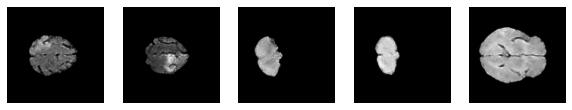

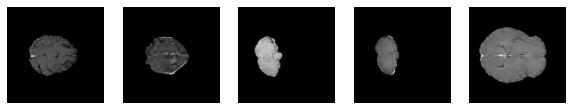

total_loss: 1.0185 -- quant_loss: 0.9645 -- nll_loss: 0.0546 -- rec_loss: 0.0546 -- p_loss: 0.0373 -- d_weight: 0.0027 -- disc_factor: 1.0000 -- g_loss: -0.2231 -- cos_sim: 1.0336 -- disc_loss: 1.0830 -- logits_real: 0.0754 -- logits_fake: 0.2231: 100%|██████████| 1000/1000 [11:11<00:00,  1.49it/s]
total_loss: 1.0572 -- quant_loss: 1.0116 -- nll_loss: 0.0544 -- rec_loss: 0.0544 -- p_loss: 0.0366 -- d_weight: 0.0087 -- disc_factor: 1.0000 -- g_loss: -1.0215 -- cos_sim: 1.1336 -- disc_loss: 1.1289 -- logits_real: 0.8540 -- logits_fake: 1.0215: 100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]
total_loss: 0.8801 -- quant_loss: 0.8186 -- nll_loss: 0.0629 -- rec_loss: 0.0629 -- p_loss: 0.0434 -- d_weight: 0.0032 -- disc_factor: 1.0000 -- g_loss: -0.4114 -- cos_sim: 1.0781 -- disc_loss: 0.8647 -- logits_real: 0.7207 -- logits_fake: 0.4114: 100%|██████████| 1000/1000 [10:58<00:00,  1.52it/s]
total_loss: 0.8142 -- quant_loss: 0.7637 -- nll_loss: 0.0526 -- rec_loss: 0.0526 -- p_loss: 0.0364 -

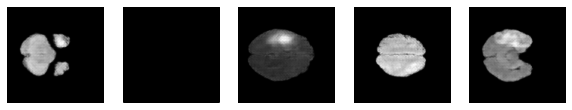

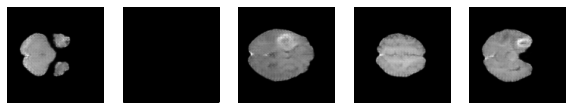

total_loss: -2.4471 -- quant_loss: 0.4387 -- nll_loss: 0.0663 -- rec_loss: 0.0663 -- p_loss: 0.0466 -- d_weight: 0.1003 -- disc_factor: 1.0000 -- g_loss: -29.4219 -- cos_sim: 1.2078 -- disc_loss: 15.2188 -- logits_real: 28.8594 -- logits_fake: 29.4219: 100%|██████████| 1000/1000 [11:08<00:00,  1.50it/s]
total_loss: -1.1556 -- quant_loss: 0.3844 -- nll_loss: 0.0447 -- rec_loss: 0.0447 -- p_loss: 0.0304 -- d_weight: 0.0295 -- disc_factor: 1.0000 -- g_loss: -53.7812 -- cos_sim: 1.3172 -- disc_loss: 27.3906 -- logits_real: 53.4688 -- logits_fake: 53.7812: 100%|██████████| 1000/1000 [11:20<00:00,  1.47it/s]
total_loss: -12.5937 -- quant_loss: 0.3831 -- nll_loss: 0.0517 -- rec_loss: 0.0517 -- p_loss: 0.0351 -- d_weight: 0.1714 -- disc_factor: 1.0000 -- g_loss: -76.0000 -- cos_sim: 1.2006 -- disc_loss: 38.5000 -- logits_real: 75.5625 -- logits_fake: 76.0000: 100%|██████████| 1000/1000 [11:05<00:00,  1.50it/s]
total_loss: -4.4275 -- quant_loss: 0.3527 -- nll_loss: 0.0446 -- rec_loss: 0.0446 --

In [4]:
from models.vector_quantized_autoencoder import VQAutoencoder
from models.lpips import VQLPIPSWithDiscriminator

AMP = True
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

ae = VQAutoencoder(
    IN_CHANNELS,
    OUT_CHANNELS, 
    n_embed=8192, 
    embed_dim=2, 
    z_channels=2, 
    z_double=False,
    pemb_dim=128,
    num_channels=128,
    channels_mult=[1, 2, 4],
    num_res_blocks=2
).to(device)

loss = VQLPIPSWithDiscriminator(
    disc_start=11, codebook_weight=1.0, pixel_weight=1.0, perceptual_weight=1.0, cos_weight=0.,
    disc_weight=0.75, d_input_channels=IN_CHANNELS, d_channels=64, d_num_layers=3
).to(device)
# model = torch.compile(model)

count_params(ae, verbose=True)

lr_g_factor = 1.0
ae_optimizer = torch.optim.AdamW(ae.parameters(), lr=0.00001, weight_decay=1e-7, betas=(0.5, 0.9))
d_optimizer = torch.optim.AdamW(loss.discriminator.parameters(), lr=lr_g_factor * 0.00001, weight_decay=1e-7, betas=(0.5, 0.9))

ae_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    ae_optimizer, T_max=train_loader.__len__() * AE_EPOCHS, eta_min=1e-9, last_epoch=-1
)

ae_scaler = torch.cuda.amp.GradScaler(enabled=AMP)
d_scaler = torch.cuda.amp.GradScaler(enabled=AMP)
total_loss_history = []

for epoch in range(AE_EPOCHS):
    ae.train()
    ae_optimizer.zero_grad(set_to_none=True)
    total_accumulated_loss = []
    ae_accumulate_loss, d_accumulated_loss = [], []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, (x_a, x_b, pos) in enumerate(train_loader):
        B = x_a.shape[0]
        x_a, x_b = x_a.to(device, dtype=torch.float32), x_b.to(device, dtype=torch.float32)
        pos = pos.to(device, dtype=torch.long)

        with torch.autocast(device.type, enabled=AMP):
            x = torch.cat([x_a, x_b], dim=1)
            x_recon, z_i, qloss, ind = ae(x, pos, return_indices=True)
            
            ae_loss, log_dict_ae = loss(
                qloss, x, torch.tanh(x_recon), z_i, 0, epoch * len(train_loader) + idx, last_layer=ae.decoder.out_conv[-1].weight
            )
            
            d_loss, log_dict_disc = loss(
                qloss, x, torch.tanh(x_recon.detach()), z_i, 1, epoch * len(train_loader) + idx, last_layer=ae.decoder.out_conv[-1].weight
            )

        log_dict = {**log_dict_ae, **log_dict_disc}

        ae_scaler.scale(ae_loss).backward()
        d_scaler.scale(d_loss).backward()

        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            ae_scaler.unscale_(ae_optimizer)
            ae_scaler.step(ae_optimizer)
            ae_scaler.update()
            ae_scheduler.step()
            ae_optimizer.zero_grad(set_to_none=True)

            d_scaler.unscale_(d_optimizer)
            d_scaler.step(d_optimizer)
            d_scaler.update()
            d_optimizer.zero_grad(set_to_none=True)

            ae_accumulate_loss.append(ae_loss.item())
            d_accumulated_loss.append(d_loss.item())
            total_accumulated_loss.append((ae_loss + d_loss).item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                # progress.set_description(
                #     f"Epoch: {epoch + 1}/{AE_EPOCHS} " + \
                #     f"| AE loss: {np.mean(ae_accumulate_loss):.4f} " + \
                #     f"| D loss: {np.mean(d_accumulated_loss):.4f} " + \
                #     f"| Total loss: {np.mean(total_accumulated_loss):.4f}"
                # )
                progress.set_description(
                    format_dict(log_dict)
                )

    total_loss_history.append(np.mean(total_accumulated_loss))

    n_sample = BATCH_SIZE if BATCH_SIZE < 5 else 5
    if (epoch + 1) % 5 == 0:
        for c in range(IN_CHANNELS):
            with torch.no_grad():
                plt.figure(figsize=(10, 2))
                for i in range(n_sample):
                    plt.subplot(1, n_sample, i + 1)
                    plt.imshow(torch.tanh(x_recon[i, c, :, :]).detach().cpu().numpy(), cmap='gray')
                    plt.axis('off')
                plt.show()


### Saving model

In [4]:
save_checkpoint = {
    'model_state_dict': ae.state_dict(),
    'optimizer_state_dict': ae_optimizer.state_dict(),
    'loss': total_loss_history,
    'epoch': epoch,
    'description': 'AE with VQ-VAE and discriminator and cosine similarity, takes FLAIR and T1CE as input and reconstructs them.'
}

torch.save(save_checkpoint, f'weights/ae_{epoch}.pth')
print('model saved')

model saved


### Loading the model

In [6]:
from models.vector_quantized_autoencoder import VQAutoencoder

ae = VQAutoencoder(
    IN_CHANNELS, 
    OUT_CHANNELS, 
    n_embed=8192, 
    embed_dim=4, 
    z_channels=8, 
    z_double=False, 
    pemb_dim=128,
    num_channels=128,
    channels_mult=[1, 2, 4, 4], 
    attn=[False, False, False, True],
    num_res_blocks=2
).to(device)

ckpt = torch.load('weights/ae_1999.pth')
ae.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

### Some inference

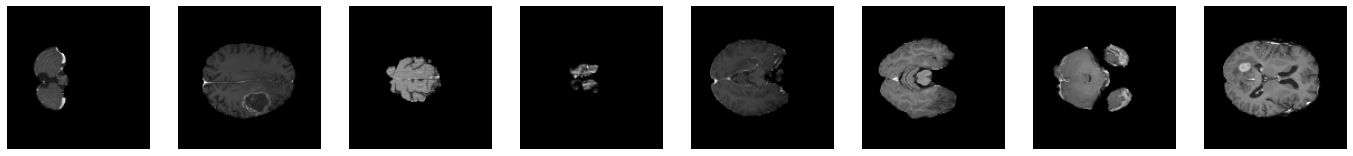

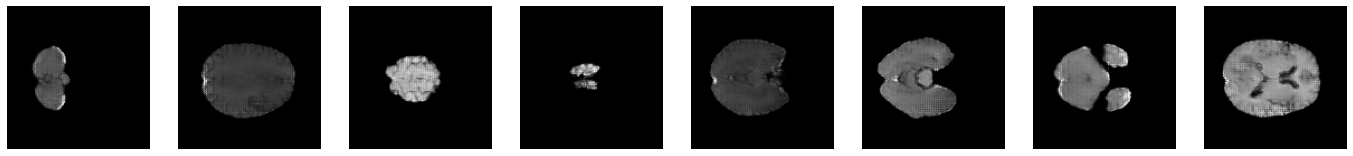

In [37]:
rand_idx = np.random.randint(0, 32000, size=(8,))
pos = slice_positions[rand_idx]
with torch.no_grad():
    originals = np.concatenate([flair[rand_idx], t1ce[rand_idx]], axis=1)
    originals = torch.from_numpy(originals).to(device, dtype=torch.float32)
    reconstructed, z_i, qloss = ae(originals, pos)
    reconstructed = torch.tanh(reconstructed)
    for c, vec in enumerate([originals, reconstructed]):
        plt.figure(figsize=(24, 8))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(vec[i, 1, :, :].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

In [8]:
from models.vector_quantized_autoencoder import VQAutoencoder
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# constants
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
BATCH_SIZE = 8
AE_EPOCHS = 2000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Imported')
print('Used device:', device)

ae = VQAutoencoder(
    IN_CHANNELS, 
    OUT_CHANNELS, 
    n_embed=8192, 
    embed_dim=4, 
    z_channels=8, 
    z_double=False, 
    pemb_dim=128,
    num_channels=128,
    channels_mult=[1, 2, 4, 4], 
    attn=[False, False, False, True],
    num_res_blocks=2
).to(device)

x = torch.randn(2, 2, 128, 128).to(device)
pos = torch.randint(0, 64, size=(2,), dtype=torch.long, device=device)



Imported
Used device: cuda


In [9]:
x, z_i, qloss, indices = ae(x, pos, return_indices=True)

In [21]:
import torch
a, b = torch.randn(2, 4, 4)
torch.cosine_similarity(a, b)

TypeError: cosine_similarity() got an unexpected keyword argument 'reduction'